## Import libraries

In [1]:
import pathlib
import isthmuslib as isli
from typing import List, Optional, Set
import pandas as pd
from loguru import logger
from tqdm.auto import tqdm

## Config

In [2]:
transactions_file: pathlib.Path = pathlib.Path("/home/m/Projects/GitHub/monero_fingerprinting_pipeline/output/flattened/all/transactions_flattened.feather")
output_dir: pathlib.Path = pathlib.Path() / "analysis_outputs"
limit: Optional[int] = None  # 1_000_000

## Load data

In [3]:
txns: isli.VectorMultiset = isli.VectorMultiset().read_any(transactions_file, inplace=False)
logger.info(f"Loaded {len(txns.data)} transactions")
if limit:
    txns.data = txns.data.tail(limit)
    logger.info(f"Trimmed to {len(txns.data)} transactions")

2023-06-11 15:00:23.989 | INFO     | __main__:<module>:2 - Loaded 12870955 transactions


## Use analysis (drop structure)

Flatten across transactions

In [4]:
all_indices: List[int] = []
for ring_member_list in txns.data["flat_ring_members"]:
    all_indices.extend(ring_member_list)

Count uses

In [5]:
series: pd.Series = pd.Series(all_indices)
value_counts = series.value_counts()
df = value_counts.reset_index()
df.columns = ["output_index", "use_count"]
df.sort_values(by="use_count", ascending=False, inplace=True)

Review results (tabular and viz)

In [6]:
df.head()

,output_index,use_count
0,36209202,11723
1,36207815,11723
2,36205121,11722
5,36187496,11722
6,36185669,11722


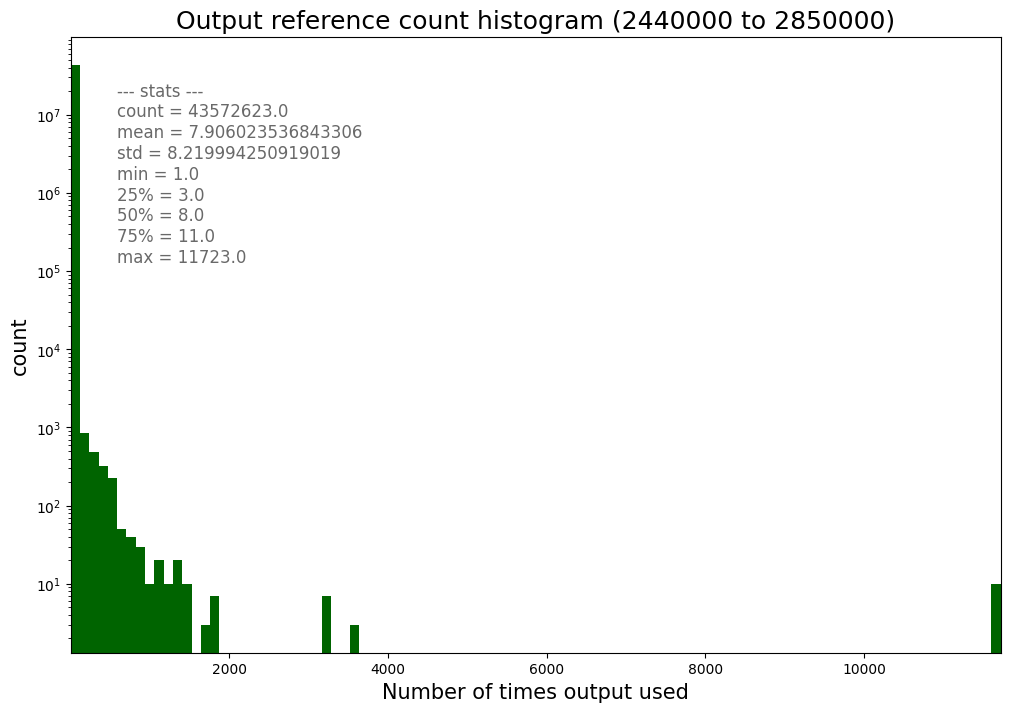

In [7]:
ring_range: str = f"{min(txns.data.block_height)} to {max(txns.data.block_height)}"
isli.hist(
    df["use_count"].tolist(),
    bins=100,
    log_axes="y",
    xlabel="Number of times output used",
    ylabel="count",
    title=f"Output reference count histogram ({ring_range})",
    describe=True,
    figsize=(12, 8),
);

In [8]:
# Save to file
output_dir.mkdir(exist_ok=True, parents=True)
use_count_filename: str = f"output_use_count_{ring_range.replace(' ','_')}.csv"
df.to_csv(output_dir / use_count_filename, index=False)
print(f"Wrote {len(df)} rows to {use_count_filename}")

Wrote 43572623 rows to output_use_count_2440000_to_2850000.csv


## Use analysis (retain structure)

In [9]:
logger.info(f"Starting with {len(txns.data)} rows")
df_adjust = txns.data.copy()

# Explode `flat_ring_members` to create a new row for each member
logger.info(f"Exploding `flat_ring_members`")
df_adjust = df_adjust.explode("flat_ring_members")

# Group by `flat_ring_members` and aggregate `tx_hash` into lists
logger.info(f"Grouping by `flat_ring_members`")
result_df = df_adjust.groupby("flat_ring_members")["tx_hash"].agg(list).reset_index()
result_df.columns = ["output_index", "tx_hash"]

# Adding count col
logger.info(f"Adding count col")
result_df["uses"] = [len(x_) for x_ in result_df["tx_hash"]]

# Sort for convenience
logger.info(f"Sorting")
result_df.sort_values(by="uses", ascending=False, inplace=True)

# Save to file
output_dir.mkdir(exist_ok=True, parents=True)
inverted_use_count_filename: str = f"output_use_count_inverted_{ring_range.replace(' ','_')}.csv"
result_df.to_csv(output_dir / inverted_use_count_filename, index=False)
print(f"Wrote {len(result_df)} rows to {inverted_use_count_filename}")

# Print or return the resulting DataFrame
print(result_df)

2023-06-11 15:15:50.860 | INFO     | __main__:<module>:1 - Starting with 12870955 rows
2023-06-11 15:15:51.874 | INFO     | __main__:<module>:5 - Exploding `flat_ring_members`
2023-06-11 15:16:31.559 | INFO     | __main__:<module>:9 - Grouping by `flat_ring_members`
2023-06-11 15:33:51.029 | INFO     | __main__:<module>:14 - Adding count col
2023-06-11 15:34:01.754 | INFO     | __main__:<module>:18 - Sorting


Wrote 43572623 rows to output_use_count_inverted_2440000_to_2850000.csv
          output_index                                            tx_hash   
9383660       36209202  [08f2f37fc7362f5db7a3a62fd17a25a0674f82e25c270...  \
9382682       36207815  [08f2f37fc7362f5db7a3a62fd17a25a0674f82e25c270...   
9380742       36205121  [08f2f37fc7362f5db7a3a62fd17a25a0674f82e25c270...   
9380095       36204221  [08f2f37fc7362f5db7a3a62fd17a25a0674f82e25c270...   
9374826       36196909  [08f2f37fc7362f5db7a3a62fd17a25a0674f82e25c270...   
...                ...                                                ...   
10322258      37390852  [36e7c947f95c8ee10f35616672f788ad6ffd488e0364e...   
10322260      37390854  [71cda911692f021815817e0af4b7bd8497ea3feb8c717...   
10322264      37390858  [9fcc2ea458e9c475284c29d7f903a6fa7ee6f133f635e...   
10322269      37390864  [7ab2d2e726c03d947ab3e5db33cd610b030c011a72e46...   
43572622      70700139  [7fd8e1c9fa8c3e0d82c37f3384cda2f59bdbd948f9c40...   

   

## Spot check

In [10]:
list(set(result_df["tx_hash"].iloc[0]))[:5]

['091db006c6fa81617895eb098f074cc3a35cda0b124c14e968fbc75da1dfe7df',
 '656cf882186ed04220886124a71d4f060b7f38278b00522f894d1bf5be46c741',
 '7fbf4bee696bf0bc534d130e1bec2d6d59e0a113224c4b5a7dea7bb906e35186',
 '39ee21547cc020eeda59da7434b9f4eae5b6ee1e02b85026b4be0b576c77ed74',
 'c5f6bb40f90df5690fba4dc92230674c2e1ad85deeb936704fcc34b34fdfe0b1']

### Save examples of dupes, ringxor style
https://xmrchain.net/search?value=79ba8cd9c8fedaeb1f23cc758235568987776fe6374da6dd28f09884c701cb50
https://xmrchain.net/search?value=b8a3530ffac558729064bd6536fe8010e87f3ed198179fb9bdec66b79b3c161d
https://xmrchain.net/search?value=32bba27641f54325d931ad73d6277a0dcf6d57983385f81688ea1223d5a5614d

## Build list of overused transactions

25 percentile: 3.0
50 percentile: 8.0
75 percentile: 11.0
90 percentile: 14.0
99 percentile: 20.0
99.9 percentile: 30.0
99.99 percentile: 56.0


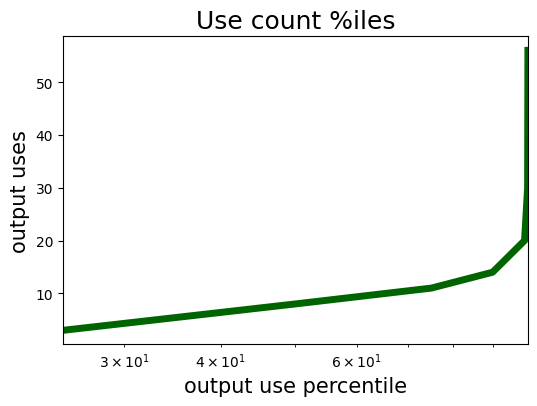

In [11]:
percentiles = [25, 50, 75, 90, 99, 99.9, 99.99]
percentile_values: List[int] = []
for percentile in percentiles:
    value = result_df["uses"].quantile(percentile / 100)
    percentile_values.append(value)
    print(f"{percentile} percentile: {value}")

isli.plot(
    percentiles,
    percentile_values,
    xlabel="output use percentile",
    ylabel="output uses",
    title="Use count %iles",
    figsize=(6, 4),
    log_axes="x",
);

## Label above certain percentile

In [12]:
max_percentile: float = 99.9
max_uses: int = result_df["uses"].quantile(max_percentile / 100)
overused_df = result_df[result_df["uses"] > max_uses]
overused_label_list: Set[str] = set()
for tx_hash_list in tqdm(overused_df["tx_hash"]):
    overused_label_list.update(tx_hash_list)
logger.info(f"{max_percentile}th percentile corresponds to {max_uses} uses")
logger.info(f"Found {len(overused_label_list)} transactions with output use count > {max_uses}")

  0%|          | 0/43048 [00:00<?, ?it/s]

2023-06-11 15:40:10.262 | INFO     | __main__:<module>:7 - 99.9th percentile corresponds to 30.0 uses
2023-06-11 15:40:10.263 | INFO     | __main__:<module>:8 - Found 820305 transactions with output use count > 30.0


Write the list out to a text file

In [13]:
output_dir.mkdir(exist_ok=True, parents=True)
with open(
    output_dir / f"overused_txns_{ring_range.replace(' ','_')}_for_{max_percentile}th_percentile_{max_uses}_max.txt", "w"
) as f:
    for tx_hash in overused_label_list:
        f.write(f"{tx_hash}\n")
    logger.info(f"Wrote {len(overused_label_list)} transactions to {f.name}")

2023-06-11 15:40:10.484 | INFO     | __main__:<module>:7 - Wrote 820305 transactions to analysis_outputs/overused_txns_2440000_to_2850000_for_99.9th_percentile_30.0_max.txt
